# Libraries and functions initialization

In [250]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 40)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [355]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)
scenario = "chen.2"

registerDoParallel(cores = 4)
number.of.iters <- 20

offset = 0.1
lambda = 1

In [252]:
test <- GetSimulationData(test.data.sample.size, scenario = scenario)
train <- GetSimulationData(sample.size, scenario = scenario)

# Simulation specific functions

# Analysis

Отличаются только тем, что GetInitPars не вычитает min(quantile, 0), а сразу берет 1-q наилучших наград

In [100]:
lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
# train$reward <- residuals(lm_model)
test.prediction <- with(test, predict(lm_model, data.frame(raw.R = raw.reward, covariates)))

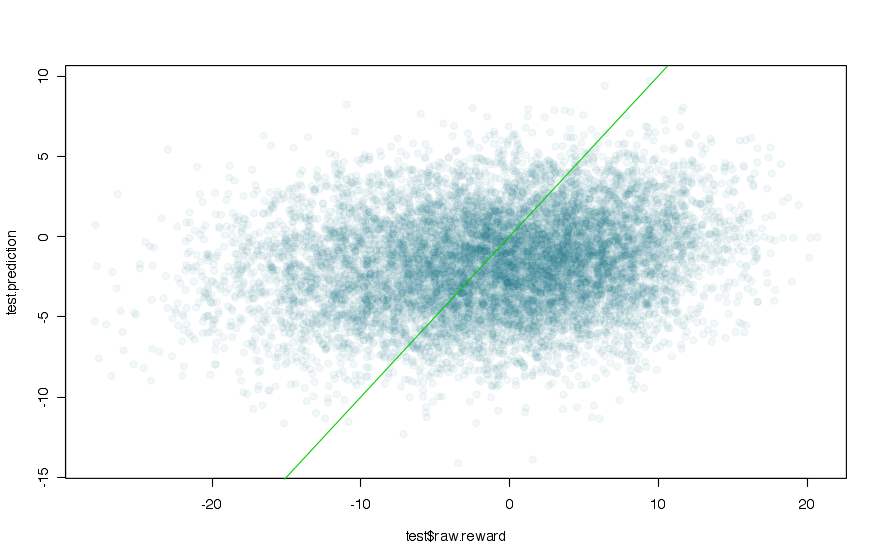

In [101]:
plot(test$raw.reward, test.prediction, col=rgb(0, 0.4, 0.5, 0.05), pch=19)
abline(a=0, b=1, col=3)

In [193]:
rlm_model <- with(train, rlm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))

In [216]:
for (n in names(rewards.q.adjusted)) {
    print(n)
    reward.adj = rewards.q.adjusted[[n]]
    train$reward <- reward.adj
    OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)

}

[1] "MM.10%.adjusted"
[1] "MM.20%.adjusted"
[1] "MM.30%.adjusted"
[1] "MM.40%.adjusted"
[1] "MM.50%.adjusted"
[1] "MM.60%.adjusted"
[1] "MM.70%.adjusted"


ERROR: Error: sum(abs.deviance < 1e-17) == 0 is not TRUE


In [279]:
library(randomForest)

In [306]:
rf_model <- with(train, randomForest(covariates,  raw.reward, ntree=1000, mtry=3)) 

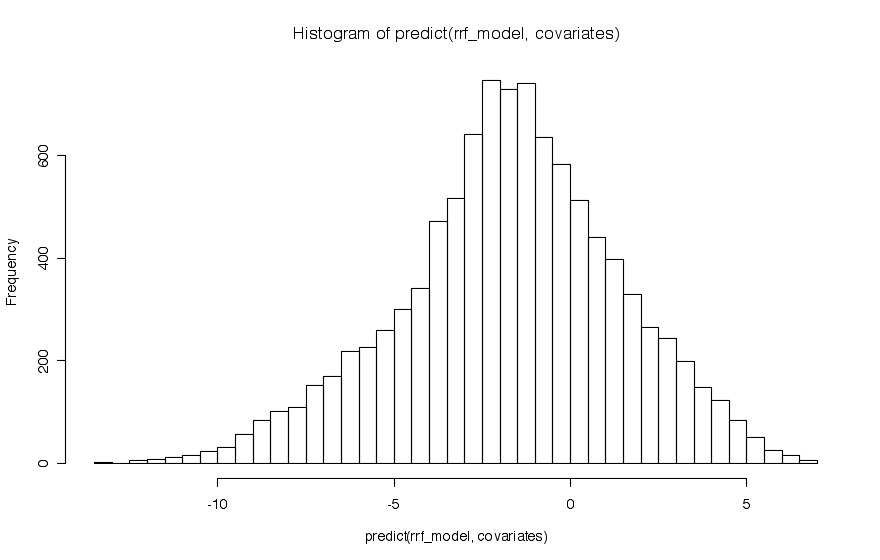

In [338]:
with(test, hist(predict(rrf_model, covariates), breaks=50))

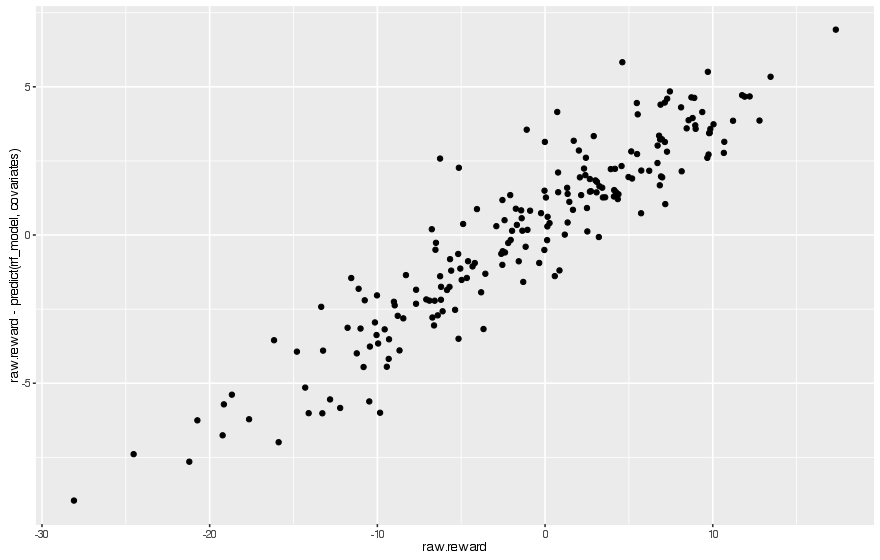

In [331]:
with(train, qplot(raw.reward, raw.reward - predict(rrf_model, covariates)))

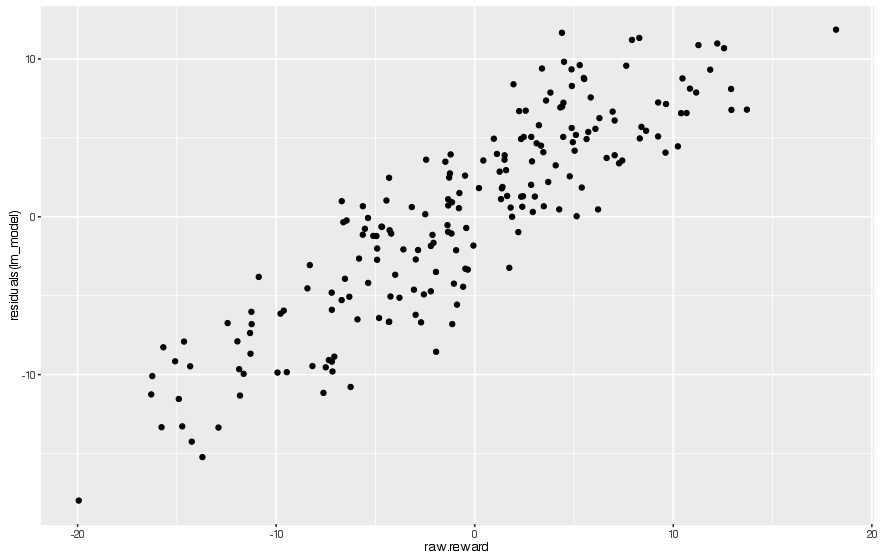

In [315]:
lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
with(train, qplot(raw.reward, residuals(lm_model)))

In [ ]:
print("ok")

In [ ]:
print(lm_model)

In [351]:
l <- with(train, lowess(data.frame(raw.R = raw.reward, covariates[, -1])))

In [ ]:
library(caret)
library(gbm)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       63.9390             nan     0.1000    1.3238
     2       61.7528             nan     0.1000    0.9395
     3       60.2688             nan     0.1000    0.7719
     4       58.7776             nan     0.1000    0.7814
     5       57.1973             nan     0.1000    1.2677
     6       55.4364             nan     0.1000    0.5700
     7       53.8384             nan     0.1000    0.8799
     8       53.2319             nan     0.1000   -0.1673
     9       51.6093             nan     0.1000    0.9366
    10       50.3189             nan     0.1000   -0.2963
    20       42.7460             nan     0.1000   -0.5436
    40       34.6158             nan     0.1000    0.2489
    50       31.9611             nan     0.1000   -0.2033



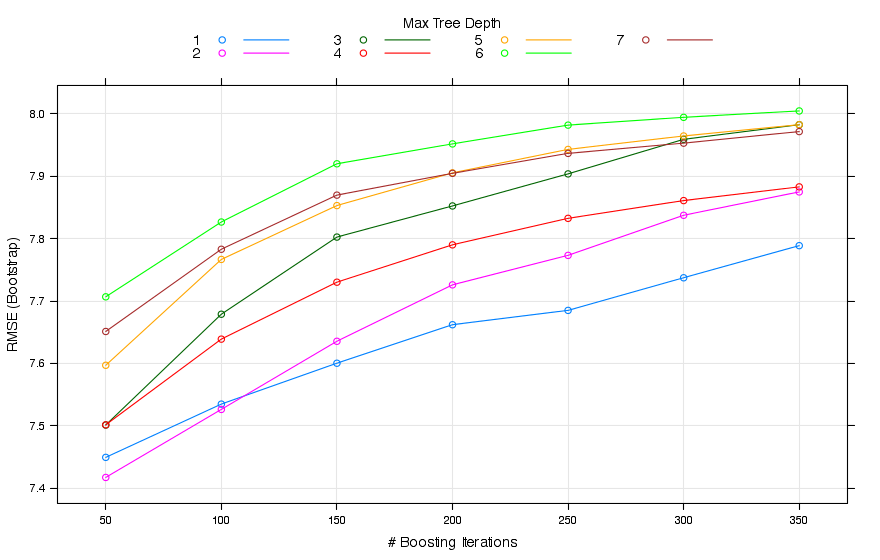

In [330]:
gbm_model <- with(train, train(raw.R ~ ., data=data.frame(raw.R = raw.reward, covariates[, -1]), method="gbm", tuneLength = 7))
plot(gbm_model)

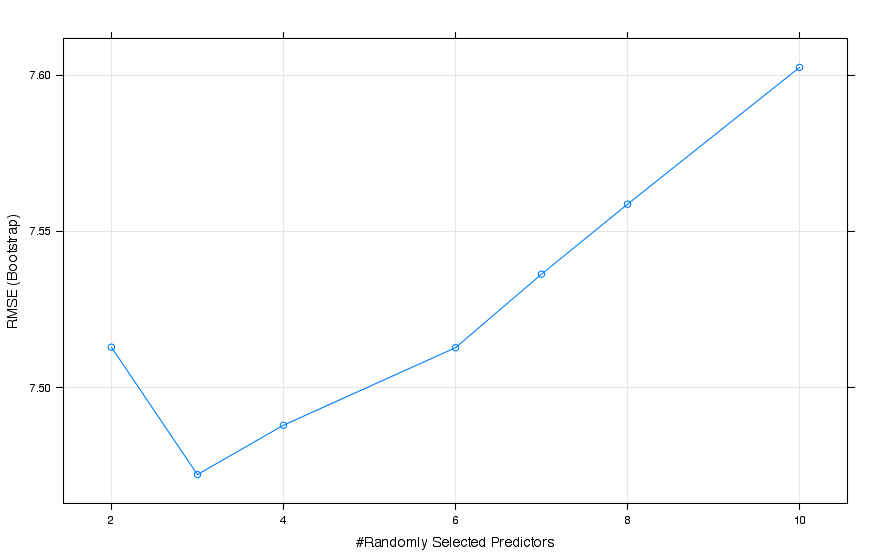

In [329]:
rrf_model <- with(train, train(raw.R ~ ., data=data.frame(raw.R = raw.reward, covariates[, -1]), method="rf", tuneLength = 7 ))
plot(rrf_model)

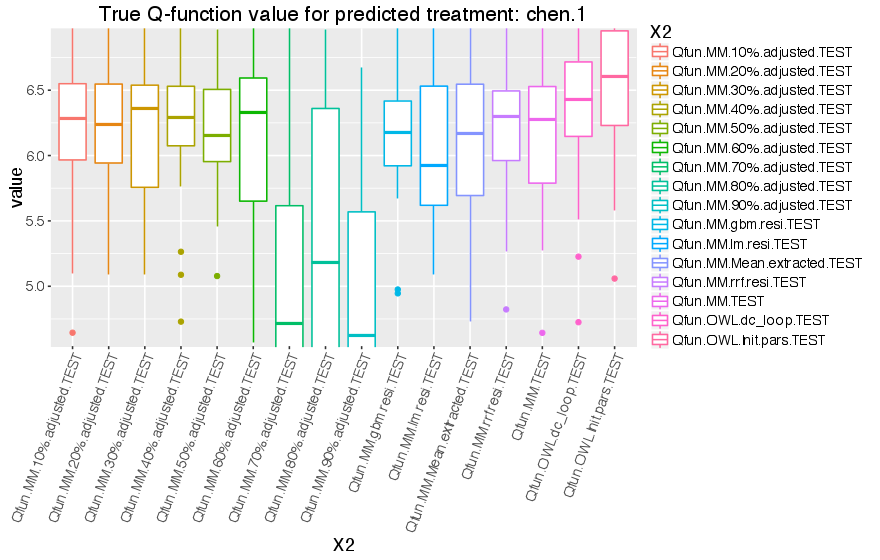

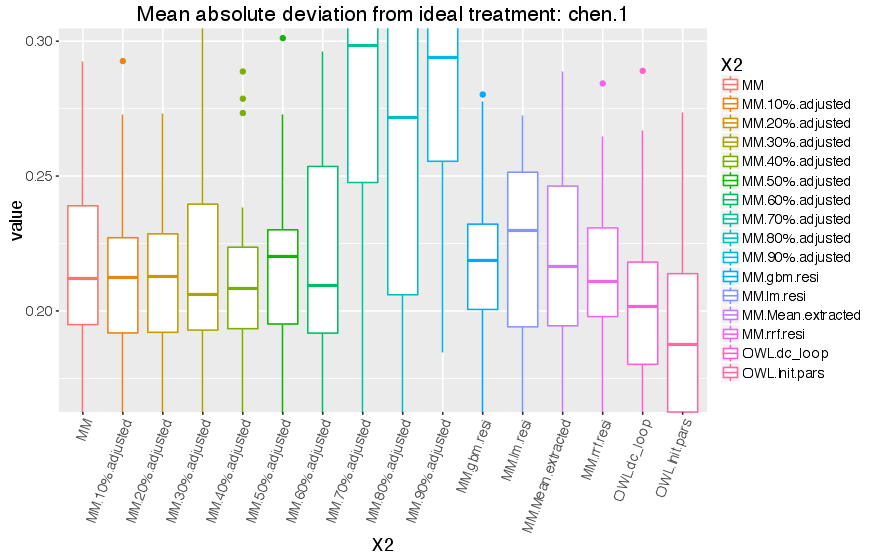

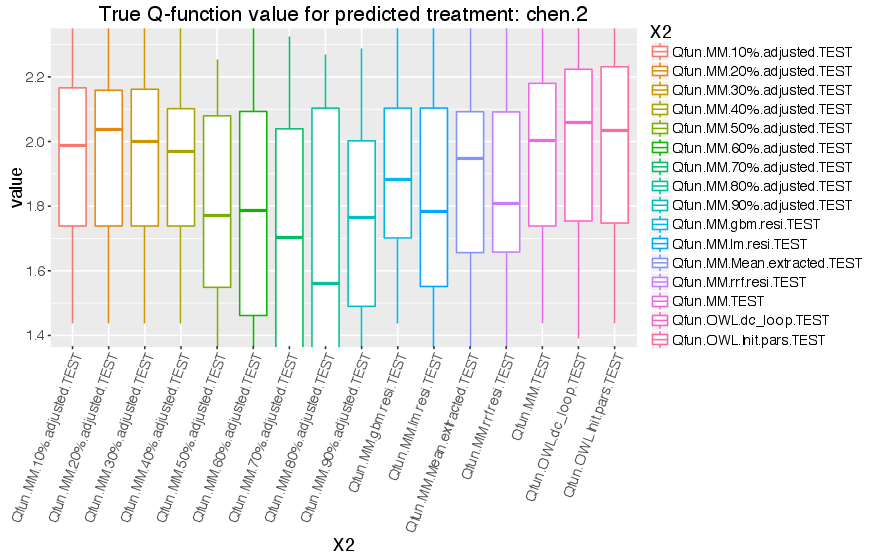

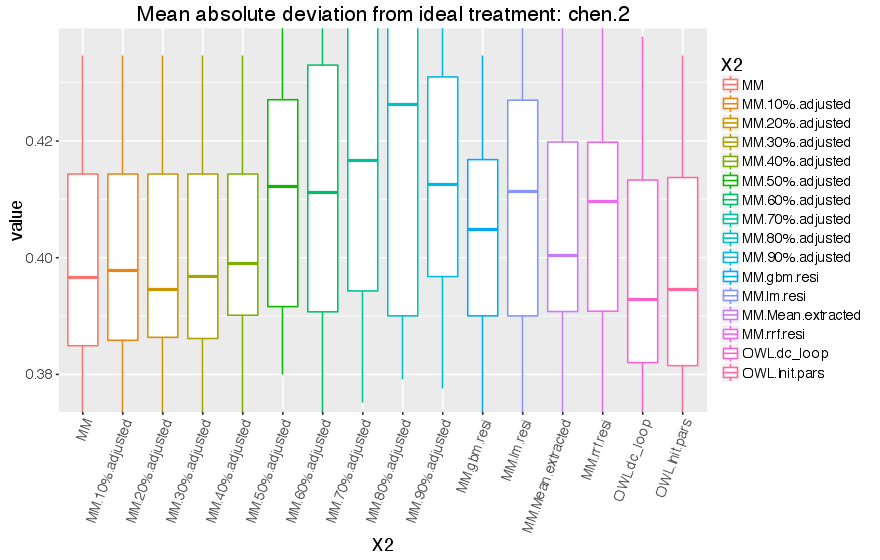

In [356]:
quants <- seq(10, 90, 10) / 100

for (scenario in c("chen.1", "chen.2")) {
    global.stat <- numeric()
    global.abs.dev <- numeric()
    test <- GetSimulationData(test.data.sample.size, scenario = scenario) 
    for (i in seq(1,number.of.iters)) { 
        train <- GetSimulationData(sample.size, scenario = scenario)
        ## Without correction
        init.pars = GetOwlParams(train, lambda, weights = F)
        opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
        pars.dca.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        pars.owl.dc_loop <- GetDCLoopPars(train, offset, lambda, init.pars)
        ## Correction
        lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
        train$reward <- residuals(lm_model)
        pars.dca.MM.res <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        train$reward <- with(train, raw.reward - mean(raw.reward))
        pars.dca.MM.mean.extracted <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        rewards.q.adjusted <- lapply(quantile(train$raw.reward, quants), function(q) with(train, {raw.reward - q}))
        names(rewards.q.adjusted) <- sapply(names(rewards.q.adjusted), function(n) paste("MM", n, "adjusted", sep = "."))
        pars.dca.MM.quants.extracted <- lapply(rewards.q.adjusted, function(reward.adj) {
            train$reward <- reward.adj
            OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        })
        
        # experiment with randomForest 
        rf_model <- with(train, randomForest(covariates,  raw.reward, ntree=1000, mtry=3)) 
        train$reward <- with(train, raw.reward - predict(rf_model, covariates))
        pars.dca.MM.res.rrf <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
            
        # experiment with boosting
        gbm_model <- with(train, train(raw.R ~ ., data=data.frame(raw.R = raw.reward, covariates[, -1]), method="gbm", tuneLength = 7, verbose = FALSE))
        train$reward <- with(train, raw.reward - predict(gbm_model, covariates))
        pars.dca.MM.res.gbm <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        
            
            
        data.list <- list("train"=train, "test"=test)
        params.list  <- list(
                             "OWL.Init.pars"=init.pars,
                             "MM"=pars.dca.MM, 
                             "OWL.dc_loop"=pars.owl.dc_loop, 
                             "MM.lm.resi"=pars.dca.MM.res, 
                             "MM.Mean.extracted" = pars.dca.MM.mean.extracted, 
                             "MM.rrf.resi" = pars.dca.MM.res.rrf, 
                             "MM.gbm.resi" = pars.dca.MM.res.gbm
                            ) 
        params.list <- c(params.list, pars.dca.MM.quants.extracted)
        iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
        global.stat  <- rbind(global.stat, iter.stat)
        mean.abs.deviation <- sapply(params.list, 
            function(p) with(test, mean(abs(optimal.treatment - PolicyFunLinearKernel(p, covariates)))))
        global.abs.dev <- rbind(global.abs.dev, mean.abs.deviation)

    }

    rownames(global.stat) <- NULL
    q.test <- melt(global.stat[, grep("Q.*TEST", colnames(global.stat))])
    gg <- ggplot(q.test)  + 
        geom_boxplot(aes(X2, value, color=X2)) + 
        theme(axis.text.x=element_text(angle = 70, hjust=1), text = element_text(size=15)) +         
        ggtitle(paste("True Q-function value for predicted treatment:", scenario))
    gg <- gg + coord_cartesian(ylim=quantile(gg$data$value, c(0.1, 0.9))) 
    print(gg)
    rownames(global.abs.dev) <- NULL
    gg <- ggplot(melt(global.abs.dev)) + 
        geom_boxplot(aes(X2, value,  colour=X2)) + 
        theme(axis.text.x=element_text(angle = 70, hjust = 1), text = element_text(size=15)) + 
        ggtitle(paste("Mean absolute deviation from ideal treatment:", scenario))
    gg <- gg + coord_cartesian(ylim=quantile(gg$data$value, c(0.1, 0.9))) 
    print(gg)
}

# Experiments with substracting different statistics from Reward

###  Substract regression of R on X

In [5]:
lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
train$reward <- residuals(lm_model)
test.prediction <- with(test, predict(lm_model, data.frame(raw.R = raw.reward, covariates)))

In [6]:
train$reward <- residuals(lm_model)
test$reward <- with(test, raw.reward - predict(lm_model, data.frame(raw.R = raw.reward, covariates)))

# Experiments with substracting different statistics from Reward

###  Substract regression of R on X

In [13]:
GetDCLoopPars(train, offset, lambda, init.pars)

ERROR: Error in coef(dc_loop(covariates[, -1], treatment, reward, offset, lambda, : error in evaluating the argument 'object' in selecting a method for function 'coef': Error in rq.wfit(X, Y, tau = tau, weights, method, ...) : 
  negative weights not allowed
Calls: dc_loop -> rq -> rq.wfit



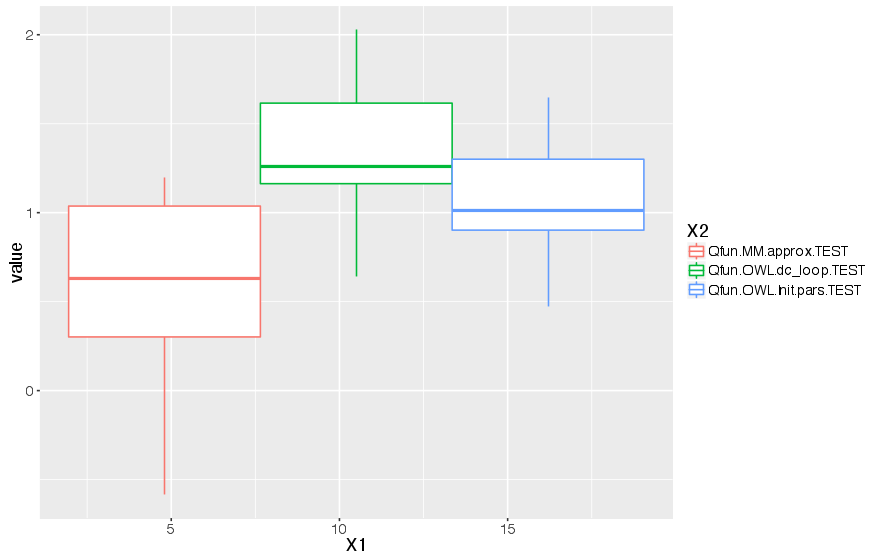

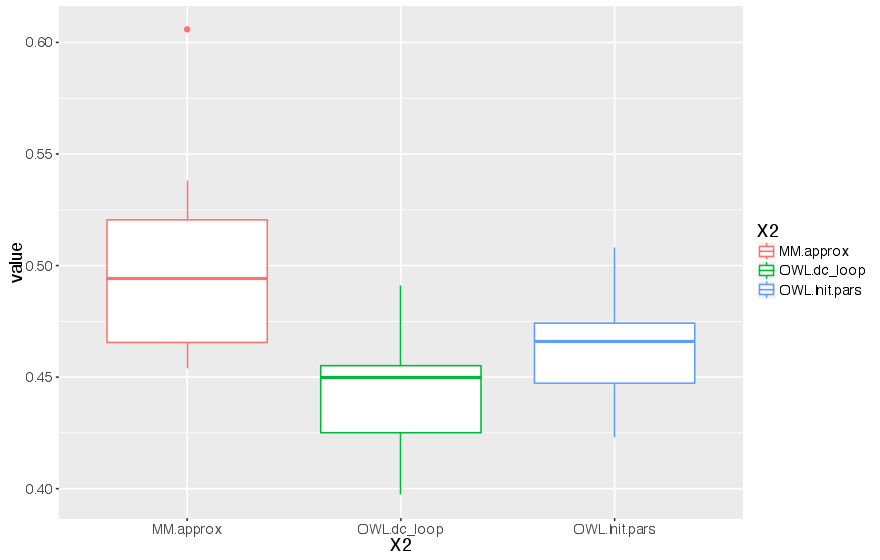

In [16]:
global.stat <- numeric()
global.abs.dev <- numeric()

for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates, scenario = scenario)
    pars.owl.dc_loop <- GetDCLoopPars(train, offset, lambda, init.pars)
    lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
    train$reward <- residuals(lm_model)
    init.pars = GetOwlParams(train, lambda, weights = F)
    opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
    pars.dca.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)

    data.list <- list("train"=train, "test"=test)
    params.list  <- list(
                         "OWL.Init.pars"=init.pars,
                         "MM.approx"=pars.dca.MM, 
                         "OWL.dc_loop"=pars.owl.dc_loop
                        ) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
    mean.abs.deviation <- sapply(params.list, 
        function(p) with(test, mean(abs(optimal.treatment - PolicyFunLinearKernel(p, covariates)))))
    global.abs.dev <- rbind(global.abs.dev, mean.abs.deviation)
    
}
                                
rownames(global.stat) <- NULL
q.test <- melt(global.stat[, grep("Q.*TEST", colnames(global.stat))])
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))
                                 
rownames(global.abs.dev) <- NULL
ggplot(melt(global.abs.dev)) + geom_boxplot(aes(X2, value,  colour=X2)) + theme(text = element_text(size=15))    